In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib  
import matplotlib.pyplot as plt 
import seaborn

import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from scipy.interpolate import interp1d
from scipy.optimize import minimize

import re

In [2]:
## Neural network tools
def get_batches(arrays, batch_size=None, randomise=False, include_remainder=True):
    length = len(arrays[0])
    idx = np.arange(length)

    if randomise:
        np.random.shuffle(idx)

    n_full_batches = length // batch_size
    is_remainder = (length % batch_size > 0)

    if is_remainder and include_remainder:
        n_batches = n_full_batches + 1
    else:
        n_batches = n_full_batches

    for i_batch in range(n_batches):
        if i_batch < n_full_batches:
            batch_idx = idx[i_batch*batch_size:(i_batch+1)*batch_size]
        else:
            batch_idx = idx[i_batch*batch_size:]

        arrays_batch = [torch.Tensor(array[batch_idx]) for array in arrays]
        yield arrays_batch

def get_total_loss(model, loss, X, y, mean_over_batch=False):
    eval_batch_size = min(1024*2**8,len(X))
    losses = [] # contain loss from every batch

    with torch.no_grad():
        for X_tensor, y_tensor in get_batches([X, y], eval_batch_size):
            output = model(X_tensor)
            losses.append(loss(output, y_tensor).item()*len(output))

        if mean_over_batch:
            mean_loss = sum(losses) / len(losses)
        else:
            mean_loss = sum(losses) / len(X)

    return mean_loss

def get_network_output(df, features, model):
    with torch.no_grad():
        X = df[features].to_numpy() #Now check what corrections are for test_df

        eval_batch_size = min(1024*2**8,len(df))
        outputs = []

        for X_tensor, in get_batches([X], eval_batch_size):
              outputs.append(model(X_tensor).numpy())

        output = np.concatenate(outputs)

    return output

In [24]:
# Plot options
color_map = {
    "data" : "black",
    "mc" : "red",
    "mc_rwgt" : "cornflowerblue"
}

var_range = {
    'corr_weight' : (0,2),
    'probe_s4' : (0.4,1.0),
    'probe_r9' : (0.5,1.1),
    'probe_hoe' : (0,0.08),
    'probe_etaWidth' : (0.003,0.0125),
    'probe_sieie' : (0.006, 0.012),
    'probe_s4_T' : (-3,3),
    'probe_r9_T' : (-3,3),
    'probe_hoe_T' : (-3,3),
    'probe_etaWidth_T' : (-3,3),
    'probe_sieie_T' : (-3,3),
    'f' : (0.35,.75)
}

nbins = 40

In [4]:
columns = ['probe_s4','probe_sieie', 'probe_r9', 'probe_etaWidth', 'probe_hoe', 'probe_eta']
data = pd.read_parquet("Data_F_subset.parquet", columns=columns)
columns = ['probe_raw_s4','probe_raw_sieie', 'probe_raw_r9', 'probe_raw_etaWidth', 'probe_raw_hoe', 'probe_eta']
mc = pd.read_parquet("DY_postEE_subset.parquet", columns=columns)
rename_dict = {}
for col in columns:
    if "raw" in col: 
        rename_dict[col] = re.sub("_raw", "", col)
mc = mc.rename(columns=rename_dict)

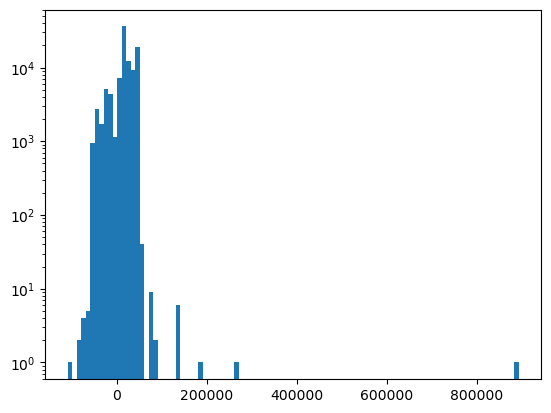

In [36]:
# PROBLEM WITH NEGATIVE WEIGHTS
fig, ax = plt.subplots()
ax.hist(df['weight'], bins=100, range=(df['weight'].min(),df['weight'].max()))
ax.set_yscale("log")

In [5]:
# Just barrel
mask = abs(data['probe_eta']) < 1.5
data = data[mask]

mask = abs(mc['probe_eta']) < 1.5
# Make sure they are the same size
mc = mc[mask][:len(data)]

In [6]:
# Define variables
variables = ['probe_s4','probe_sieie', 'probe_r9', 'probe_etaWidth', 'probe_hoe']

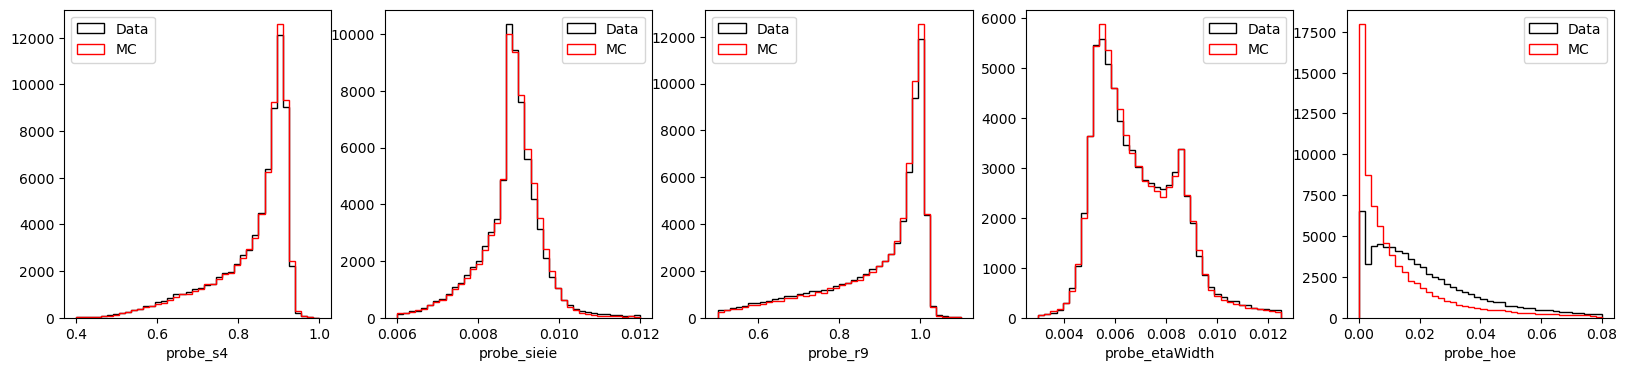

In [7]:
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
for i,var in enumerate(variables):
    h_data = axs[i].hist(data[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], label='Data')
    h_mc = axs[i].hist(mc[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label='MC')
    axs[i].set_xlabel(var) 
    axs[i].legend(loc='best')

In [8]:
# Concatenate dataframes and get means and std
total = pd.concat([data,mc])
mean = np.array(total[variables].mean())
std = np.array(total[variables].std())
# Calculate percentiles for clipped variables
pmin, pmax = 2.5,97.5
vmin, vmax = np.percentile(total[variables], pmin, axis=0), np.percentile(total[variables], pmax, axis=0)

In [9]:
vars_clipped = np.clip(data[variables], vmin, vmax)
vars_clipped_T = (vars_clipped-mean)/std
vars_T = (data[variables]-mean)/std
for v in variables:
    data[f"{v}_T"] = vars_T[v]
    data[f"{v}_T_clipped"] = vars_clipped_T[v]

vars_clipped = np.clip(mc[variables], vmin, vmax)
vars_clipped_T = (vars_clipped-mean)/std
vars_T = (mc[variables]-mean)/std
for v in variables:
    mc[f"{v}_T"] = vars_T[v]
    mc[f"{v}_T_clipped"] = vars_clipped_T[v]

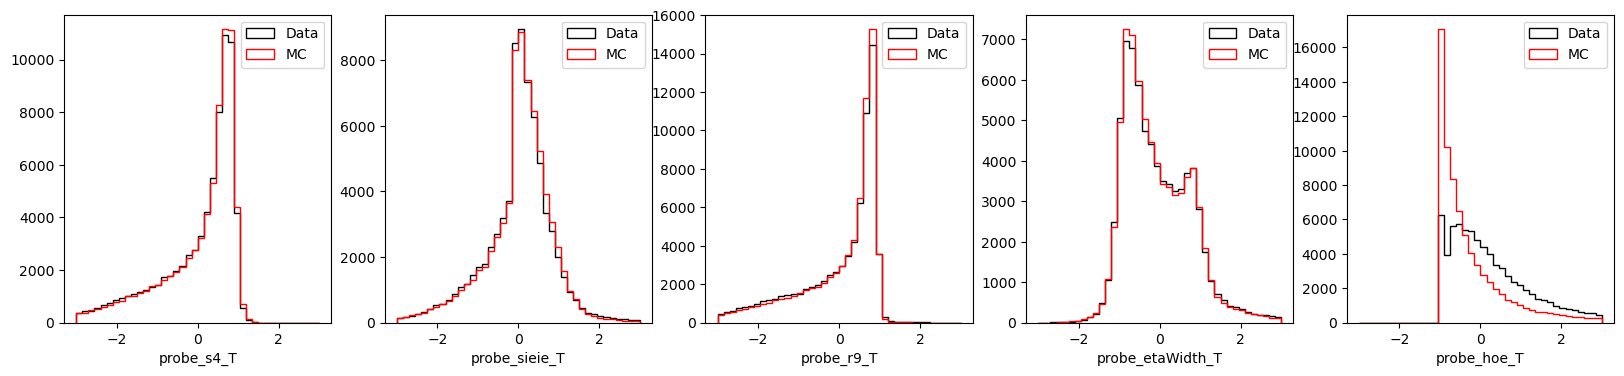

In [10]:
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
for i,var in enumerate(variables):
    var = f"{var}_T"
    h_data = axs[i].hist(data[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], label='Data')
    h_mc = axs[i].hist(mc[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label='MC')
    axs[i].set_xlabel(var) 
    axs[i].legend(loc='best')

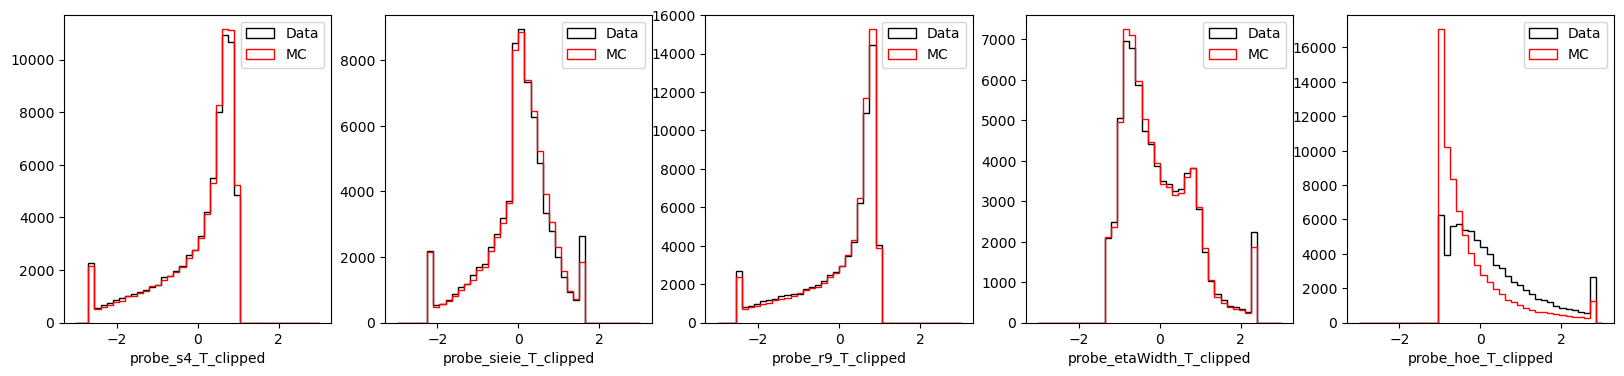

In [11]:
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
for i,var in enumerate(variables):
    varr = f"{var}_T"
    var = f"{var}_T_clipped"
    h_data = axs[i].hist(data[var], bins=nbins, range=var_range[varr], histtype='step', color=color_map['data'], label='Data')
    h_mc = axs[i].hist(mc[var], bins=nbins, range=var_range[varr], histtype='step', color=color_map['mc'], label='MC')
    axs[i].set_xlabel(var) 
    axs[i].legend(loc='best')

### Define network

In [12]:
# Training hyperparameters
train_hp = {
    "lr":0.0001,
    "batch_size":10000,
    "N_epochs":300,
    "seed":0
}

# Set seed
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(train_hp['seed'])

In [13]:
class Net(nn.Module):
    def __init__(self, n_features=2, nodes=[50,50], output_nodes=1):
        super(Net, self).__init__()
        # Build network
        n_nodes = [n_features] + nodes + [output_nodes]
        self.layers = nn.ModuleList()
        for i in range(len(n_nodes)-1):
            self.layers.append(nn.Linear(n_nodes[i], n_nodes[i+1]))
            self.layers.append(nn.Tanh())

    def forward(self, x):
        out = self.layers[0](x)
        for layer in self.layers[1:]:
            out = layer(out)
        # Apply sigmoid
        return torch.sigmoid(out)

In [14]:
# Function to train network with cross entropy loss
def train_network_bce(model, train_df, test_df, features=['probe_s4_t','probe_sieie_t'], train_hp={}):
    optimiser = torch.optim.Adam(model.parameters(), lr=train_hp["lr"])

    X_train = train_df[features].to_numpy()
    X_test = test_df[features].to_numpy()
    y_train = torch.Tensor(train_df["is_data"].to_numpy()).unsqueeze(1) #train_df["is_data"].to_numpy()
    y_test = torch.Tensor(test_df["is_data"].to_numpy()).unsqueeze(1) #test_df["is_data"].to_numpy()

    bce_loss = nn.BCELoss()
    train_loss, test_loss = [], []

    print(">> Training...")
    with tqdm(range(train_hp["N_epochs"])) as t:
        for i_epoch in t:
            model.train()

            batch_gen = get_batches([X_train, y_train], batch_size=train_hp['batch_size'],
                                    randomise=True, include_remainder=False
                                   )
            
            for X_tensor, y_tensor in batch_gen:
                optimiser.zero_grad()
                output = model(X_tensor)
                loss = bce_loss(output, y_tensor)
                loss.backward()
                optimiser.step()

            model.eval()
            train_loss.append(get_total_loss(model, bce_loss, X_train, y_train))
            test_loss.append(get_total_loss(model, bce_loss, X_test, y_test))
            t.set_postfix(train_loss=train_loss[-1], test_loss=test_loss[-1])

    print(">> Training finished")
    model.eval()

    return model, train_loss, test_loss

In [15]:
# Add label
data['is_data'] = 1
mc['is_data'] = 0

# Do test-train split
data_train, data_test = train_test_split(data, test_size=0.5, random_state=train_hp['seed'])
mc_train, mc_test = train_test_split(mc, test_size=0.5, random_state=train_hp['seed'])
train_df = pd.concat([data_train,mc_train]).sample(frac=1)
test_df = pd.concat([data_test,mc_test]).sample(frac=1)

In [16]:
# Initialise networks
features = ['probe_s4_T', 'probe_sieie_T']
model_bce = Net(n_features=2, nodes=[100,100,100], output_nodes=1)

#features_clipped = ['probe_s4_T_clipped', 'probe_sieie_T_clipped']
#model_bce_clipped = Net(n_features=2, nodes=[100,100,100], output_nodes=1)

In [17]:
# Train network
model_bce, train_loss_bce, test_loss_bce = train_network_bce(
    model_bce, train_df, test_df, features=features, train_hp=train_hp
)

## Train network
#model_bce_clipped, train_loss_bce_clipped, test_loss_bce_clipped = train_network_bce(
#    model_bce_clipped, train_df, test_df, features=features_clipped, train_hp=train_hp
#)

>> Training...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [03:50<00:00,  1.30it/s, test_loss=0.692, train_loss=0.692]

>> Training finished


Text(0, 0.5, 'BCE loss')

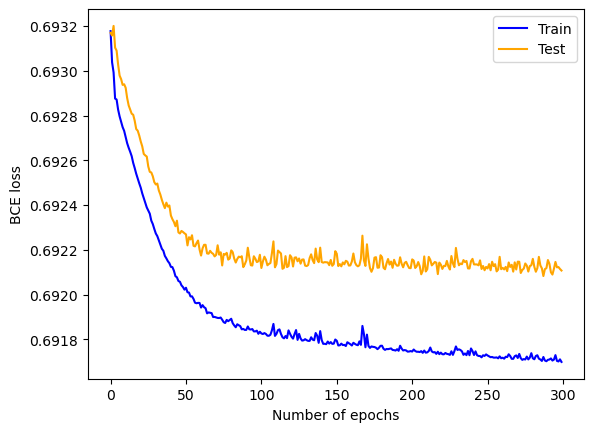

In [18]:
# Plot loss function curves
fig, ax = plt.subplots()
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), train_loss_bce, label="Train", color='blue')
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), test_loss_bce, label="Test", color='orange')
#ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), train_loss_bce_clipped, label="Train (clipped)", ls='--', color='blue')
#ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), test_loss_bce_clipped, label="Test (clipped)", ls='--', color='orange')
ax.legend(loc='best')
ax.set_xlabel("Number of epochs")
ax.set_ylabel("BCE loss")

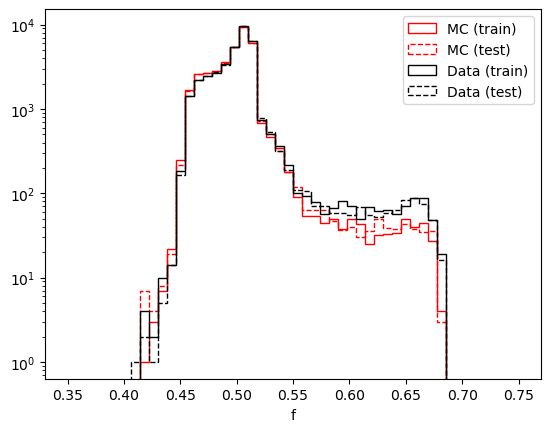

In [25]:
# Plot output score distributions
nbins=50
X_mc_train = mc_train[features].to_numpy()
f = model_bce(torch.Tensor(X_mc_train)).detach().numpy().squeeze()
mc_train['f'] = f
mc_train['corr_weight'] = f/(1-f)

X_mc_test = mc_test[features].to_numpy()
f = model_bce(torch.Tensor(X_mc_test)).detach().numpy().squeeze()
mc_test['f'] = f
mc_test['corr_weight'] = f/(1-f)

X_data_train = data_train[features].to_numpy()
f = model_bce(torch.Tensor(X_data_train)).detach().numpy().squeeze()
data_train['f'] = f

X_data_test = data_test[features].to_numpy()
f = model_bce(torch.Tensor(X_data_test)).detach().numpy().squeeze()
data_test['f'] = f

fig, axs = plt.subplots()
var = "f"
h_train = axs.hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label="MC (train)")
h_test = axs.hist(mc_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], ls='--', label="MC (test)")
h_train = axs.hist(data_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], label="Data (train)")
h_test = axs.hist(data_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], ls='--', label="Data (test)")
axs.legend(loc='best')
axs.set_xlabel(var)
axs.set_yscale("log")

#features=['probe_s4_T_clipped','probe_sieie_T_clipped']
#X_mc_train = mc_train[features].to_numpy()
#f = model_bce_clipped(torch.Tensor(X_mc_train)).detach().numpy().squeeze()
#mc_train['f_clipped'] = f
#mc_train['corr_weight_clipped'] = f/(1-f)

#X_mc_test = mc_test[features].to_numpy()
#f = model_bce_clipped(torch.Tensor(X_mc_test)).detach().numpy().squeeze()
#mc_test['f_clipped'] = f
#mc_test['corr_weight_clipped'] = f/(1-f)

#X_data_train = data_train[features].to_numpy()
#f = model_bce_clipped(torch.Tensor(X_data_train)).detach().numpy().squeeze()
#data_train['f_clipped'] = f

#X_data_test = data_test[features].to_numpy()
#f = model_bce_clipped(torch.Tensor(X_data_test)).detach().numpy().squeeze()
#data_test['f_clipped'] = f

#fig, axs = plt.subplots(1,2, figsize=(8,4))
#var = "f"
#h_train = axs[0].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label="MC (train)")
#h_test = axs[0].hist(mc_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], ls='--', label="MC (test)")
#h_train = axs[0].hist(data_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], label="Data (train)")
#h_test = axs[0].hist(data_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], ls='--', label="Data (test)")
#axs[0].legend(loc='best')
#axs[0].set_xlabel(var)
#axs[0].set_yscale("log")

#var = "f_clipped"
#h_train = axs[1].hist(mc_train[var], bins=nbins, range=var_range['f'], histtype='step', color=color_map['mc'], label="MC (train)")
#h_test = axs[1].hist(mc_test[var], bins=nbins, range=var_range['f'], histtype='step', color=color_map['mc'], ls='--', label="MC (test)")
#h_train = axs[1].hist(data_train[var], bins=nbins, range=var_range['f'], histtype='step', color=color_map['data'], label="Data (train)")
#h_test = axs[1].hist(data_test[var], bins=nbins, range=var_range['f'], histtype='step', color=color_map['data'], ls='--', label="Data (test)")
#axs[1].legend(loc='best')
#axs[1].set_xlabel(var)
#axs[1].set_yscale("log")

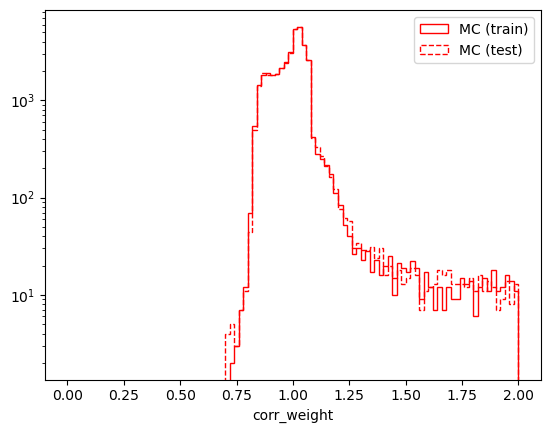

In [20]:
# Plot histogram of weights
nbins=100
fig, axs = plt.subplots()
var = 'corr_weight'
h_train = axs.hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label="MC (train)")
h_test = axs.hist(mc_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], ls='--', label="MC (test)")
axs.set_xlabel(var)
axs.set_yscale("log")
axs.legend(loc='best')

#fig, axs = plt.subplots(1,2, figsize=(8,4))
#var = 'corr_weight'
#h_train = axs[0].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label="MC (train)")
#h_test = axs[0].hist(mc_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], ls='--', label="MC (test)")
#axs[0].set_xlabel(var)
#axs[0].set_yscale("log")
#axs[0].legend(loc='best')

#var = 'corr_weight_clipped'
#h_train = axs[1].hist(mc_train[var], bins=nbins, range=var_range['corr_weight'], histtype='step', color=color_map['mc'], label="MC (train)")
#h_test = axs[1].hist(mc_test[var], bins=nbins, range=var_range['corr_weight'], histtype='step', color=color_map['mc'], ls='--', label="MC (test)")
#axs[1].set_xlabel(var)
#axs[1].set_yscale("log")
#axs[1].legend(loc='best')

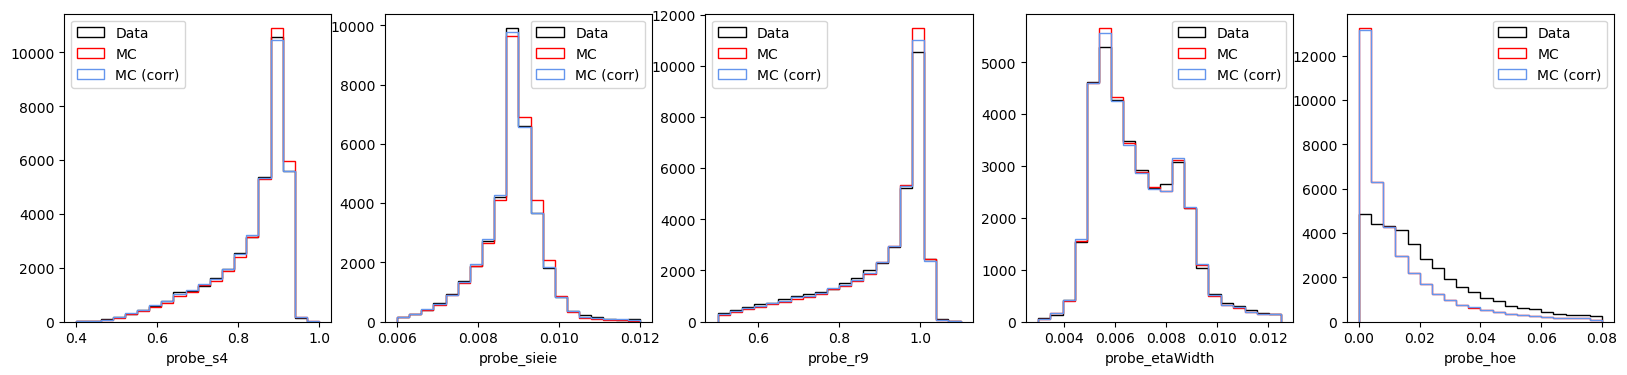

In [21]:
nbins=20
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
h_data, h_mc, h_mc_corr = {}, {}, {}
for i,var in enumerate(variables):
    h_data[var] = axs[i].hist(data_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], label='Data')
    h_mc[var] = axs[i].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label='MC')
    h_mc_corr[var] = axs[i].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc_rwgt'], label='MC (corr)', weights=mc_train['corr_weight'])
    axs[i].set_xlabel(var) 
    axs[i].legend(loc='best')

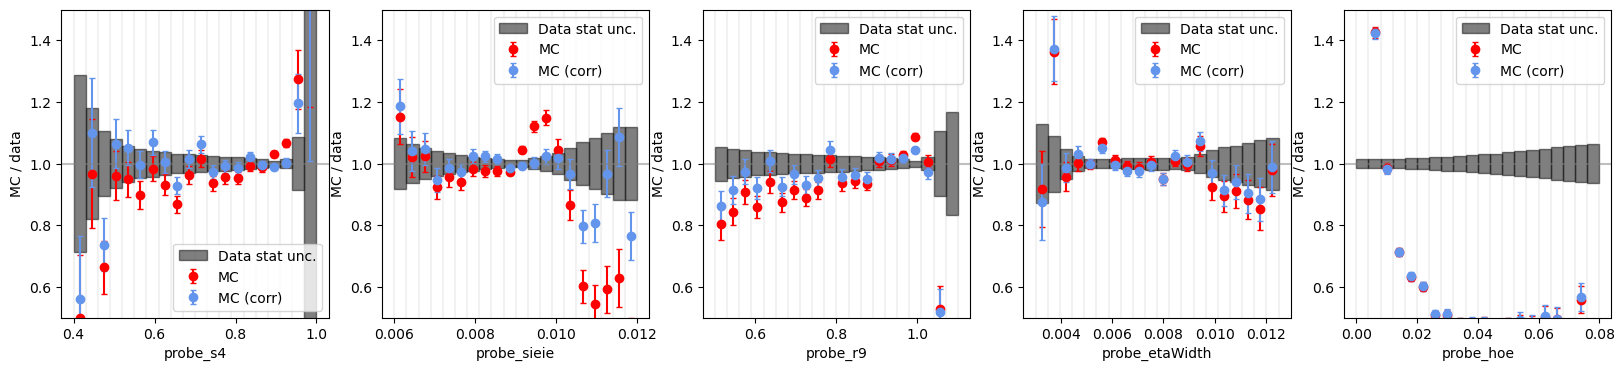

In [22]:
# Ratio plots for variables
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
for i,var in enumerate(variables):
    bin_centers = 0.5*(h_data[var][1][:-1]+h_data[var][1][1:])
    bin_widths = 0.5*(h_data[var][1][1:]-h_data[var][1][:-1])
    r = h_mc[var][0]/h_data[var][0]
    r_err = (h_mc[var][0]**0.5)/h_data[var][0]
    r_corr = h_mc_corr[var][0]/h_data[var][0]
    r_corr_err = (h_mc[var][0]**0.5)/h_data[var][0]
    axs[i].errorbar(bin_centers, r, yerr=r_err, capsize=2, ls='None', marker='o', color=color_map['mc'], label='MC')
    axs[i].errorbar(bin_centers, r_corr, yerr=r_corr_err, capsize=2, ls='None', marker='o', color=color_map['mc_rwgt'], label='MC (corr)')
    # Add stat unc. boxes
    for j in range(len(bin_widths)):
        point = (bin_centers[j]-bin_widths[j],1-h_data[var][0][j]**0.5/h_data[var][0][j])
        rect = matplotlib.patches.Rectangle(point, 2*bin_widths[j], (2*h_data[var][0][j]**0.5)/h_data[var][0][j], color='black', alpha=0.5)
        axs[i].add_patch(rect)
    axs[i].axhline(1, color='grey', alpha=0.5)
    for v in h_data[var][1]:
        axs[i].axvline(v, color='grey', alpha=0.1)
    axs[i].set_ylim(0.5,1.5)
    axs[i].set_xlabel(var)
    axs[i].set_ylabel("MC / data"),
    rect = matplotlib.patches.Rectangle((0,0), 0, 0, color='black', alpha=0.5, label='Data stat unc.')
    axs[i].add_patch(rect)
    axs[i].legend(loc='best')

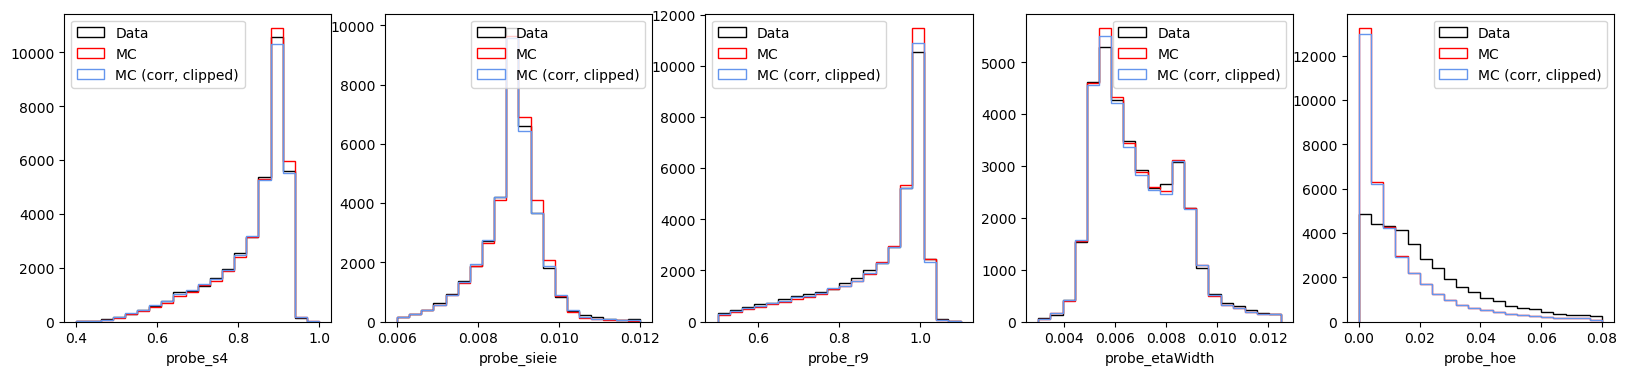

In [171]:
nbins=20
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
h_data, h_mc, h_mc_corr = {}, {}, {}
for i,var in enumerate(variables):
    h_data[var] = axs[i].hist(data_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], label='Data')
    h_mc[var] = axs[i].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label='MC')
    h_mc_corr[var] = axs[i].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc_rwgt'], label='MC (corr, clipped)', weights=mc_train['corr_weight_clipped'])
    axs[i].set_xlabel(var) 
    axs[i].legend(loc='best')

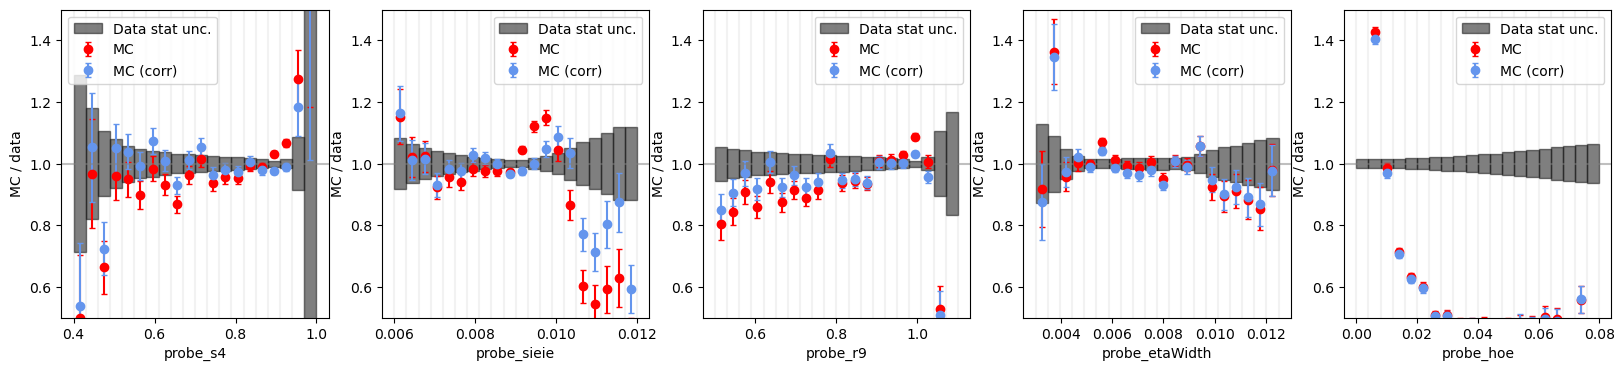

In [172]:
# Ratio plots for variables
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
for i,var in enumerate(variables):
    bin_centers = 0.5*(h_data[var][1][:-1]+h_data[var][1][1:])
    bin_widths = 0.5*(h_data[var][1][1:]-h_data[var][1][:-1])
    r = h_mc[var][0]/h_data[var][0]
    r_err = (h_mc[var][0]**0.5)/h_data[var][0]
    r_corr = h_mc_corr[var][0]/h_data[var][0]
    r_corr_err = (h_mc[var][0]**0.5)/h_data[var][0]
    axs[i].errorbar(bin_centers, r, yerr=r_err, capsize=2, ls='None', marker='o', color=color_map['mc'], label='MC')
    axs[i].errorbar(bin_centers, r_corr, yerr=r_corr_err, capsize=2, ls='None', marker='o', color=color_map['mc_rwgt'], label='MC (corr)')
    # Add stat unc. boxes
    for j in range(len(bin_widths)):
        point = (bin_centers[j]-bin_widths[j],1-h_data[var][0][j]**0.5/h_data[var][0][j])
        rect = matplotlib.patches.Rectangle(point, 2*bin_widths[j], (2*h_data[var][0][j]**0.5)/h_data[var][0][j], color='black', alpha=0.5)
        axs[i].add_patch(rect)
    axs[i].axhline(1, color='grey', alpha=0.5)
    for v in h_data[var][1]:
        axs[i].axvline(v, color='grey', alpha=0.1)
    axs[i].set_ylim(0.5,1.5)
    axs[i].set_xlabel(var)
    axs[i].set_ylabel("MC / data"),
    rect = matplotlib.patches.Rectangle((0,0), 0, 0, color='black', alpha=0.5, label='Data stat unc.')
    axs[i].add_patch(rect)
    axs[i].legend(loc='best')

In [69]:
# Plot true 2D likelihood ratio vs network output
#x = 'probe_s4'
#y = 'probe_sieie'
#fig, ax = plt.subplots()
#hist_data = ax.hist2d(data_train[x], data_train[y], bins=40, range=(var_range[x],var_range[y]), cmap='Greys', alpha=0.5)
#contours_data = ax.contour(hist_data[0], levels=100)
#hist_mc = np.histogram2d(mc_train[x], mc_train[y], bins=20, range=(var_range[x],var_range[y]))

### 4D network
Looks like the unclipped is better, let's test that

In [173]:
# Initialise networks
features = ['probe_s4_T', 'probe_sieie_T', 'probe_r9_T', 'probe_etaWidth_T']
model_bce = Net(n_features=4, nodes=[100,100,100], output_nodes=1)

In [174]:
# Train network
model_bce, train_loss_bce, test_loss_bce = train_network_bce(
    model_bce, train_df, test_df, features=features, train_hp=train_hp
)

>> Training...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [03:17<00:00,  1.52it/s, test_loss=0.692, train_loss=0.691]

>> Training finished


Text(0, 0.5, 'BCE loss')

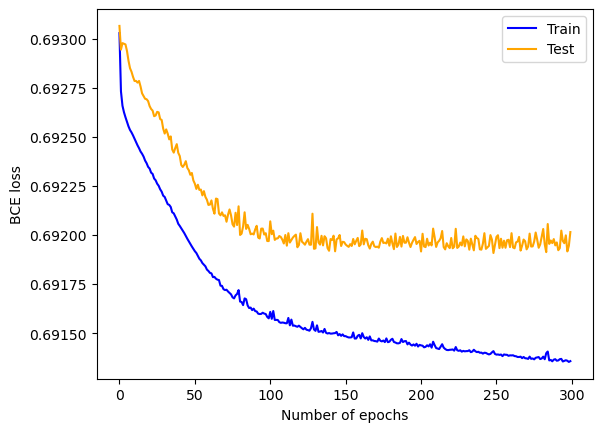

In [176]:
# Plot loss function curves
fig, ax = plt.subplots()
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), train_loss_bce, label="Train", color='blue')
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), test_loss_bce, label="Test", color='orange')
ax.legend(loc='best')
ax.set_xlabel("Number of epochs")
ax.set_ylabel("BCE loss")

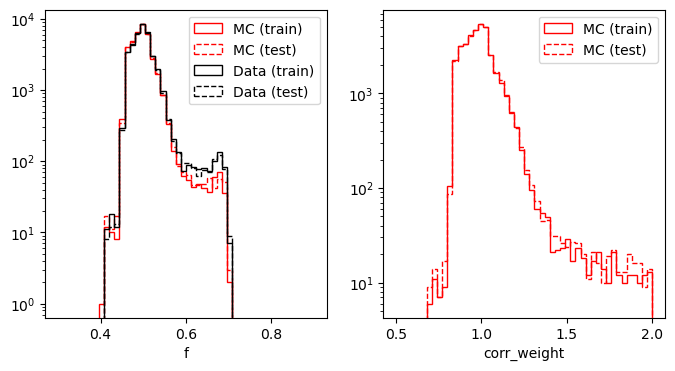

In [179]:
# Plot output score distributions
nbins=50
X_mc_train = mc_train[features].to_numpy()
f = model_bce(torch.Tensor(X_mc_train)).detach().numpy().squeeze()
mc_train['f'] = f
mc_train['corr_weight'] = f/(1-f)

X_mc_test = mc_test[features].to_numpy()
f = model_bce(torch.Tensor(X_mc_test)).detach().numpy().squeeze()
mc_test['f'] = f
mc_test['corr_weight'] = f/(1-f)

X_data_train = data_train[features].to_numpy()
f = model_bce(torch.Tensor(X_data_train)).detach().numpy().squeeze()
data_train['f'] = f

X_data_test = data_test[features].to_numpy()
f = model_bce(torch.Tensor(X_data_test)).detach().numpy().squeeze()
data_test['f'] = f

fig, axs = plt.subplots(1,2, figsize=(8,4))
var = "f"
h_train = axs[0].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label="MC (train)")
h_test = axs[0].hist(mc_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], ls='--', label="MC (test)")
h_train = axs[0].hist(data_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], label="Data (train)")
h_test = axs[0].hist(data_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], ls='--', label="Data (test)")
axs[0].legend(loc='best')
axs[0].set_xlabel(var)
axs[0].set_yscale("log")

var = 'corr_weight'
h_train = axs[1].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label="MC (train)")
h_test = axs[1].hist(mc_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], ls='--', label="MC (test)")
axs[1].set_xlabel(var)
axs[1].set_yscale("log")
axs[1].legend(loc='best')

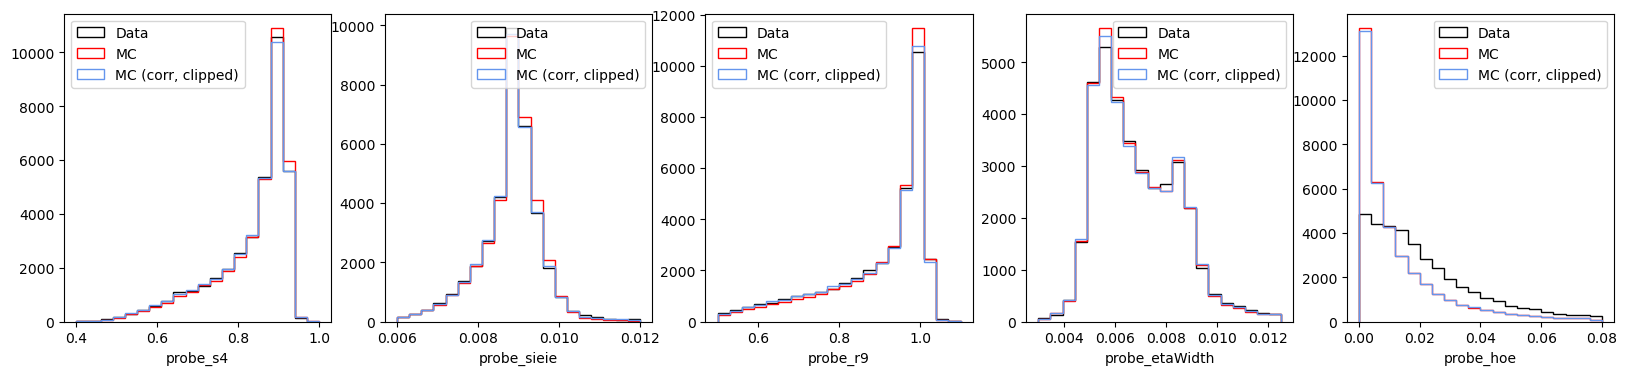

In [182]:
nbins=20
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
h_data, h_mc, h_mc_corr = {}, {}, {}
for i,var in enumerate(variables):
    h_data[var] = axs[i].hist(data_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], label='Data')
    h_mc[var] = axs[i].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label='MC')
    h_mc_corr[var] = axs[i].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc_rwgt'], label='MC (corr)', weights=mc_train['corr_weight'])
    axs[i].set_xlabel(var) 
    axs[i].legend(loc='best')

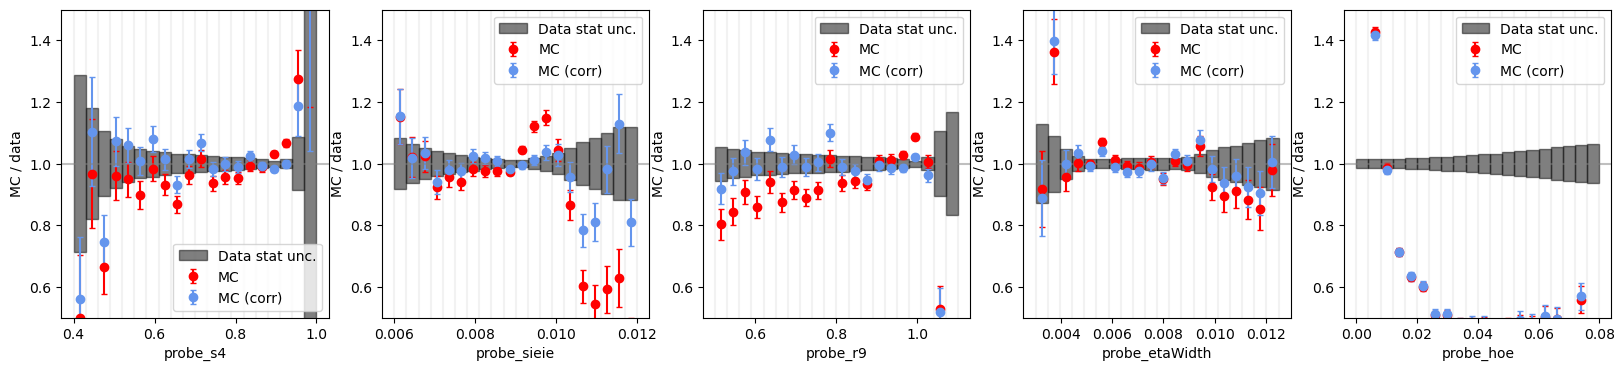

In [183]:
# Ratio plots for variables
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
for i,var in enumerate(variables):
    bin_centers = 0.5*(h_data[var][1][:-1]+h_data[var][1][1:])
    bin_widths = 0.5*(h_data[var][1][1:]-h_data[var][1][:-1])
    r = h_mc[var][0]/h_data[var][0]
    r_err = (h_mc[var][0]**0.5)/h_data[var][0]
    r_corr = h_mc_corr[var][0]/h_data[var][0]
    r_corr_err = (h_mc[var][0]**0.5)/h_data[var][0]
    axs[i].errorbar(bin_centers, r, yerr=r_err, capsize=2, ls='None', marker='o', color=color_map['mc'], label='MC')
    axs[i].errorbar(bin_centers, r_corr, yerr=r_corr_err, capsize=2, ls='None', marker='o', color=color_map['mc_rwgt'], label='MC (corr)')
    # Add stat unc. boxes
    for j in range(len(bin_widths)):
        point = (bin_centers[j]-bin_widths[j],1-h_data[var][0][j]**0.5/h_data[var][0][j])
        rect = matplotlib.patches.Rectangle(point, 2*bin_widths[j], (2*h_data[var][0][j]**0.5)/h_data[var][0][j], color='black', alpha=0.5)
        axs[i].add_patch(rect)
    axs[i].axhline(1, color='grey', alpha=0.5)
    for v in h_data[var][1]:
        axs[i].axvline(v, color='grey', alpha=0.1)
    axs[i].set_ylim(0.5,1.5)
    axs[i].set_xlabel(var)
    axs[i].set_ylabel("MC / data"),
    rect = matplotlib.patches.Rectangle((0,0), 0, 0, color='black', alpha=0.5, label='Data stat unc.')
    axs[i].add_patch(rect)
    axs[i].legend(loc='best')

# 5D network

In [187]:
# Initialise networks
features = ['probe_s4_T', 'probe_sieie_T', 'probe_r9_T', 'probe_etaWidth_T', 'probe_hoe_T']
model_bce = Net(n_features=5, nodes=[100,100,100], output_nodes=1)

In [188]:
# Train network
model_bce, train_loss_bce, test_loss_bce = train_network_bce(
    model_bce, train_df, test_df, features=features, train_hp=train_hp
)

>> Training...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [03:16<00:00,  1.53it/s, test_loss=0.643, train_loss=0.642]

>> Training finished


Text(0, 0.5, 'BCE loss')

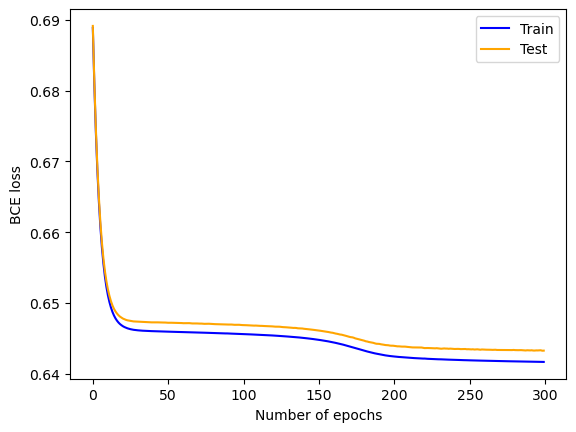

In [190]:
# Plot loss function curves
fig, ax = plt.subplots()
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), train_loss_bce, label="Train", color='blue')
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), test_loss_bce, label="Test", color='orange')
ax.legend(loc='best')
ax.set_xlabel("Number of epochs")
ax.set_ylabel("BCE loss")

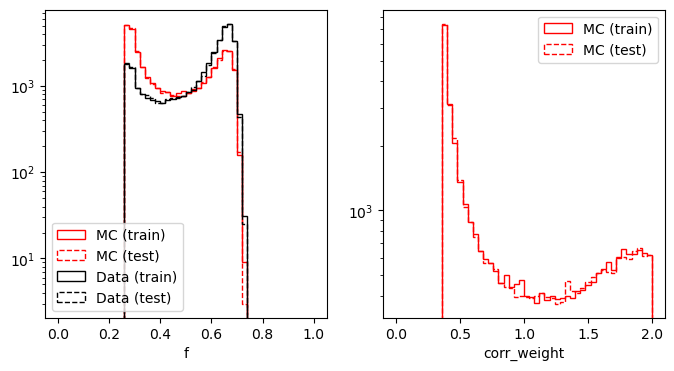

In [191]:
# Plot output score distributions
nbins=50
X_mc_train = mc_train[features].to_numpy()
f = model_bce(torch.Tensor(X_mc_train)).detach().numpy().squeeze()
mc_train['f'] = f
mc_train['corr_weight'] = f/(1-f)

X_mc_test = mc_test[features].to_numpy()
f = model_bce(torch.Tensor(X_mc_test)).detach().numpy().squeeze()
mc_test['f'] = f
mc_test['corr_weight'] = f/(1-f)

X_data_train = data_train[features].to_numpy()
f = model_bce(torch.Tensor(X_data_train)).detach().numpy().squeeze()
data_train['f'] = f

X_data_test = data_test[features].to_numpy()
f = model_bce(torch.Tensor(X_data_test)).detach().numpy().squeeze()
data_test['f'] = f

fig, axs = plt.subplots(1,2, figsize=(8,4))
var = "f"
h_train = axs[0].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label="MC (train)")
h_test = axs[0].hist(mc_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], ls='--', label="MC (test)")
h_train = axs[0].hist(data_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], label="Data (train)")
h_test = axs[0].hist(data_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], ls='--', label="Data (test)")
axs[0].legend(loc='best')
axs[0].set_xlabel(var)
axs[0].set_yscale("log")

var = 'corr_weight'
h_train = axs[1].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label="MC (train)")
h_test = axs[1].hist(mc_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], ls='--', label="MC (test)")
axs[1].set_xlabel(var)
axs[1].set_yscale("log")
axs[1].legend(loc='best')

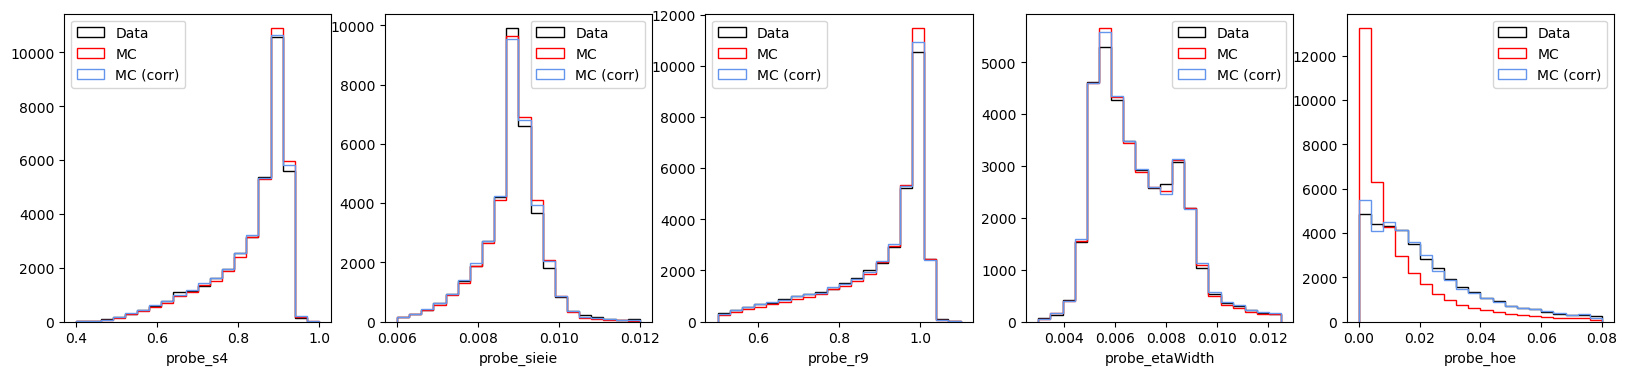

In [192]:
nbins=20
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
h_data, h_mc, h_mc_corr = {}, {}, {}
for i,var in enumerate(variables):
    h_data[var] = axs[i].hist(data_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], label='Data')
    h_mc[var] = axs[i].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label='MC')
    h_mc_corr[var] = axs[i].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc_rwgt'], label='MC (corr)', weights=mc_train['corr_weight'])
    axs[i].set_xlabel(var) 
    axs[i].legend(loc='best')

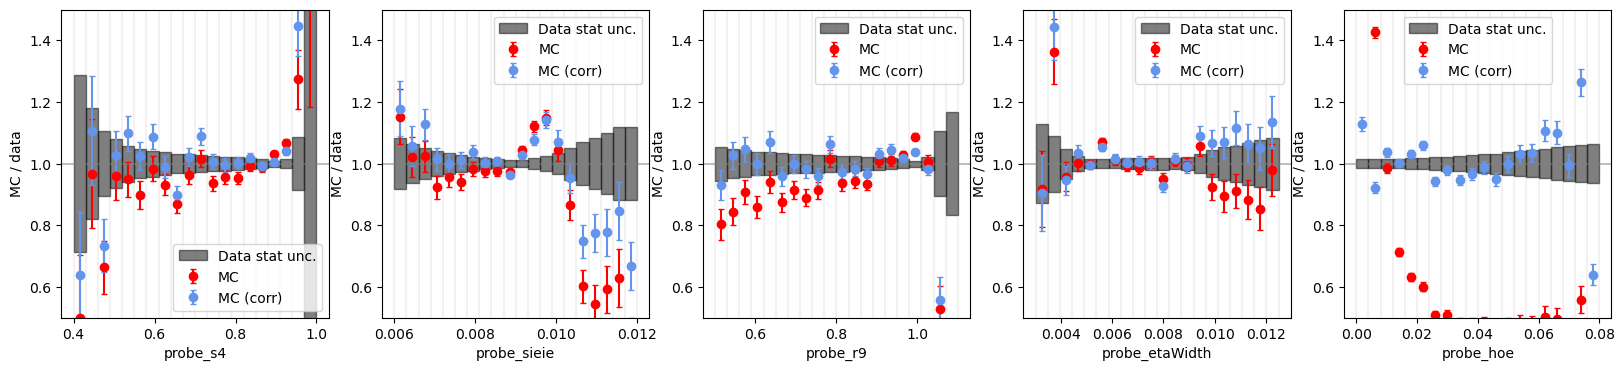

In [193]:
# Ratio plots for variables
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
for i,var in enumerate(variables):
    bin_centers = 0.5*(h_data[var][1][:-1]+h_data[var][1][1:])
    bin_widths = 0.5*(h_data[var][1][1:]-h_data[var][1][:-1])
    r = h_mc[var][0]/h_data[var][0]
    r_err = (h_mc[var][0]**0.5)/h_data[var][0]
    r_corr = h_mc_corr[var][0]/h_data[var][0]
    r_corr_err = (h_mc[var][0]**0.5)/h_data[var][0]
    axs[i].errorbar(bin_centers, r, yerr=r_err, capsize=2, ls='None', marker='o', color=color_map['mc'], label='MC')
    axs[i].errorbar(bin_centers, r_corr, yerr=r_corr_err, capsize=2, ls='None', marker='o', color=color_map['mc_rwgt'], label='MC (corr)')
    # Add stat unc. boxes
    for j in range(len(bin_widths)):
        point = (bin_centers[j]-bin_widths[j],1-h_data[var][0][j]**0.5/h_data[var][0][j])
        rect = matplotlib.patches.Rectangle(point, 2*bin_widths[j], (2*h_data[var][0][j]**0.5)/h_data[var][0][j], color='black', alpha=0.5)
        axs[i].add_patch(rect)
    axs[i].axhline(1, color='grey', alpha=0.5)
    for v in h_data[var][1]:
        axs[i].axvline(v, color='grey', alpha=0.1)
    axs[i].set_ylim(0.5,1.5)
    axs[i].set_xlabel(var)
    axs[i].set_ylabel("MC / data"),
    rect = matplotlib.patches.Rectangle((0,0), 0, 0, color='black', alpha=0.5, label='Data stat unc.')
    axs[i].add_patch(rect)
    axs[i].legend(loc='best')

* Having one variable which is severly mis-modelled clearly has negative impact on other variables (see bump in sieie)
* Loss function has second dip, perhaps where its done as much as it can on hoe and starts to concentrate on another variable?

In [196]:
# Initialise networks
features = ['probe_s4_T', 'probe_sieie_T', 'probe_r9_T', 'probe_etaWidth_T']
model_bce = Net(n_features=4, nodes=[64,128,256,128,64], output_nodes=1)

In [197]:
# Train network
model_bce, train_loss_bce, test_loss_bce = train_network_bce(
    model_bce, train_df, test_df, features=features, train_hp=train_hp
)

>> Training...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [08:12<00:00,  1.64s/it, test_loss=0.692, train_loss=0.691]

>> Training finished


Text(0, 0.5, 'BCE loss')

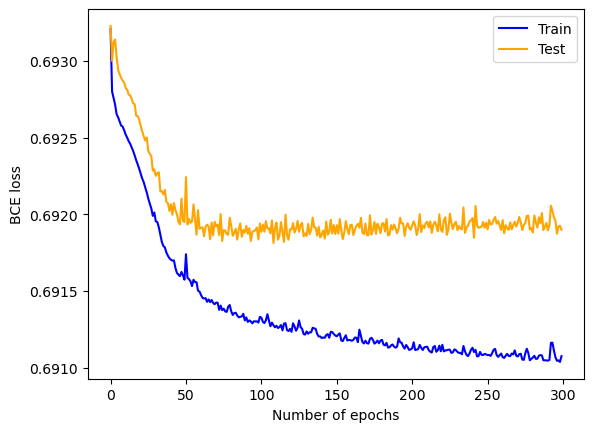

In [198]:
# Plot loss function curves
fig, ax = plt.subplots()
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), train_loss_bce, label="Train", color='blue')
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), test_loss_bce, label="Test", color='orange')
ax.legend(loc='best')
ax.set_xlabel("Number of epochs")
ax.set_ylabel("BCE loss")

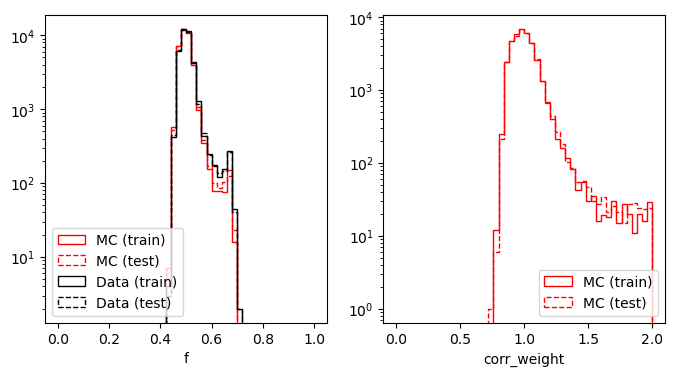

In [199]:
# Plot output score distributions
nbins=50
X_mc_train = mc_train[features].to_numpy()
f = model_bce(torch.Tensor(X_mc_train)).detach().numpy().squeeze()
mc_train['f'] = f
mc_train['corr_weight'] = f/(1-f)

X_mc_test = mc_test[features].to_numpy()
f = model_bce(torch.Tensor(X_mc_test)).detach().numpy().squeeze()
mc_test['f'] = f
mc_test['corr_weight'] = f/(1-f)

X_data_train = data_train[features].to_numpy()
f = model_bce(torch.Tensor(X_data_train)).detach().numpy().squeeze()
data_train['f'] = f

X_data_test = data_test[features].to_numpy()
f = model_bce(torch.Tensor(X_data_test)).detach().numpy().squeeze()
data_test['f'] = f

fig, axs = plt.subplots(1,2, figsize=(8,4))
var = "f"
h_train = axs[0].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label="MC (train)")
h_test = axs[0].hist(mc_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], ls='--', label="MC (test)")
h_train = axs[0].hist(data_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], label="Data (train)")
h_test = axs[0].hist(data_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], ls='--', label="Data (test)")
axs[0].legend(loc='best')
axs[0].set_xlabel(var)
axs[0].set_yscale("log")

var = 'corr_weight'
h_train = axs[1].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label="MC (train)")
h_test = axs[1].hist(mc_test[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], ls='--', label="MC (test)")
axs[1].set_xlabel(var)
axs[1].set_yscale("log")
axs[1].legend(loc='best')

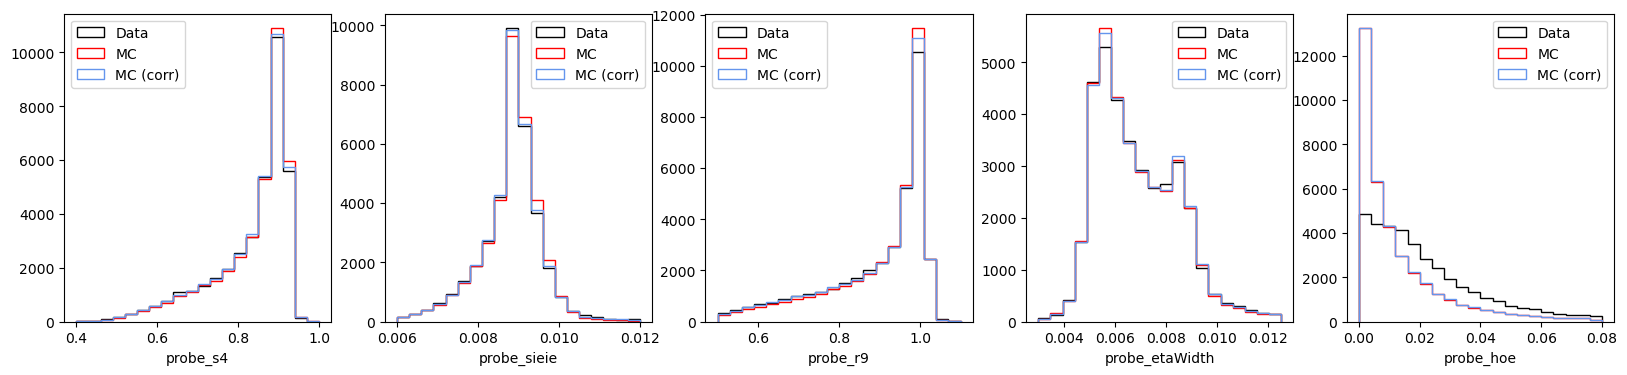

In [200]:
nbins=20
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
h_data, h_mc, h_mc_corr = {}, {}, {}
for i,var in enumerate(variables):
    h_data[var] = axs[i].hist(data_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['data'], label='Data')
    h_mc[var] = axs[i].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc'], label='MC')
    h_mc_corr[var] = axs[i].hist(mc_train[var], bins=nbins, range=var_range[var], histtype='step', color=color_map['mc_rwgt'], label='MC (corr)', weights=mc_train['corr_weight'])
    axs[i].set_xlabel(var) 
    axs[i].legend(loc='best')

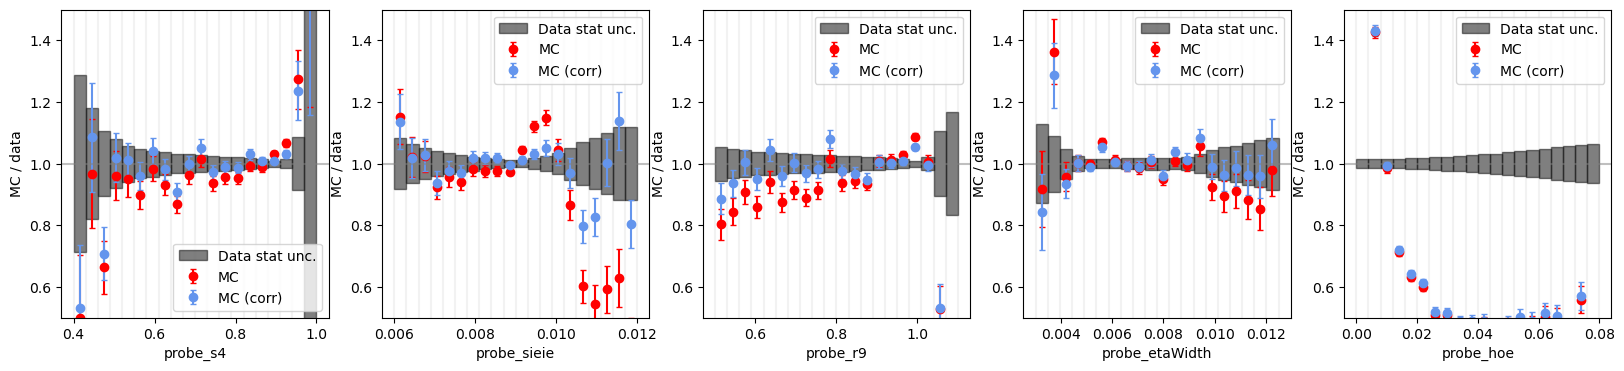

In [201]:
# Ratio plots for variables
fig, axs = plt.subplots(1, len(variables), figsize=(4*len(variables),4))
for i,var in enumerate(variables):
    bin_centers = 0.5*(h_data[var][1][:-1]+h_data[var][1][1:])
    bin_widths = 0.5*(h_data[var][1][1:]-h_data[var][1][:-1])
    r = h_mc[var][0]/h_data[var][0]
    r_err = (h_mc[var][0]**0.5)/h_data[var][0]
    r_corr = h_mc_corr[var][0]/h_data[var][0]
    r_corr_err = (h_mc[var][0]**0.5)/h_data[var][0]
    axs[i].errorbar(bin_centers, r, yerr=r_err, capsize=2, ls='None', marker='o', color=color_map['mc'], label='MC')
    axs[i].errorbar(bin_centers, r_corr, yerr=r_corr_err, capsize=2, ls='None', marker='o', color=color_map['mc_rwgt'], label='MC (corr)')
    # Add stat unc. boxes
    for j in range(len(bin_widths)):
        point = (bin_centers[j]-bin_widths[j],1-h_data[var][0][j]**0.5/h_data[var][0][j])
        rect = matplotlib.patches.Rectangle(point, 2*bin_widths[j], (2*h_data[var][0][j]**0.5)/h_data[var][0][j], color='black', alpha=0.5)
        axs[i].add_patch(rect)
    axs[i].axhline(1, color='grey', alpha=0.5)
    for v in h_data[var][1]:
        axs[i].axvline(v, color='grey', alpha=0.1)
    axs[i].set_ylim(0.5,1.5)
    axs[i].set_xlabel(var)
    axs[i].set_ylabel("MC / data"),
    rect = matplotlib.patches.Rectangle((0,0), 0, 0, color='black', alpha=0.5, label='Data stat unc.')
    axs[i].add_patch(rect)
    axs[i].legend(loc='best')

### TO-DO
* Add chi2 calculation to plots
* Try more complicated architecture?
* Fixed eta study
* 2D contour plots